In [63]:
%matplotlib inline

import warnings
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from statsmodels.api import OLS, add_constant
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)

In [3]:
with pd.HDFStore('model_tuning.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: model_tuning.h5
/catboost/factors/results             frame        (shape->[96,64])   
/lightgbm/dummies/results             frame        (shape->[216,25])  
/lightgbm/factors/results             frame        (shape->[216,25])  
/lightgbm/holdout/features            frame        (shape->[16695,84])
/lightgbm/holdout/target              series       (shape->[16695])   
/xgboost/dummies/results              frame        (shape->[216,20])  
/xgboost/holdout/features             frame        (shape->[16695,84])
/xgboost/holdout/target               series       (shape->[16695])   


In [51]:
with pd.HDFStore('results.h5') as store:
    print(store.info())
    df = store['xgb_lgb']

<class 'pandas.io.pytables.HDFStore'>
File path: results.h5
/catboost/factors            frame        (shape->[96,9])  
/lightgbm/dummies            frame        (shape->[216,10])
/lightgbm/factors            frame        (shape->[216,10])
/xgb_lgb                     frame        (shape->[1,12])  
/xgboost/dummies             frame        (shape->[1,9])   


In [52]:
df['model_type'] = df.model.str.capitalize().str.cat(df.data.str.capitalize(), sep=' ')
df = df.drop(['model', 'data'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 11 columns):
train                648 non-null float64
valid                648 non-null float64
boosting             648 non-null object
learning_rate        648 non-null float64
max_depth            648 non-null int64
num_leaves           432 non-null float64
colsample_bytree     648 non-null float64
min_gain_to_split    648 non-null int64
rounds               648 non-null float64
time                 648 non-null float64
model_type           648 non-null object
dtypes: float64(7), int64(2), object(2)
memory usage: 60.8+ KB


## XGB Parameter Usage

In [53]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [61]:
xgb_data = df[(df.model_type=='Xgb Dummies')]
xgb_data.boosting = pd.factorize(xgb_data.boosting)[0]
xgb_features = ['boosting', 'learning_rate', 'max_depth', 'colsample_bytree', 'min_gain_to_split']
reg_tree.fit(X=xgb_data[features], y=xgb_data.valid)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

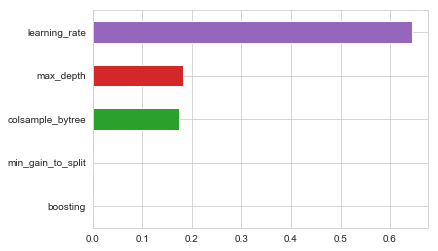

In [73]:
pd.Series(reg_tree.feature_importances_, index=xgb_features).sort_values().plot.barh();

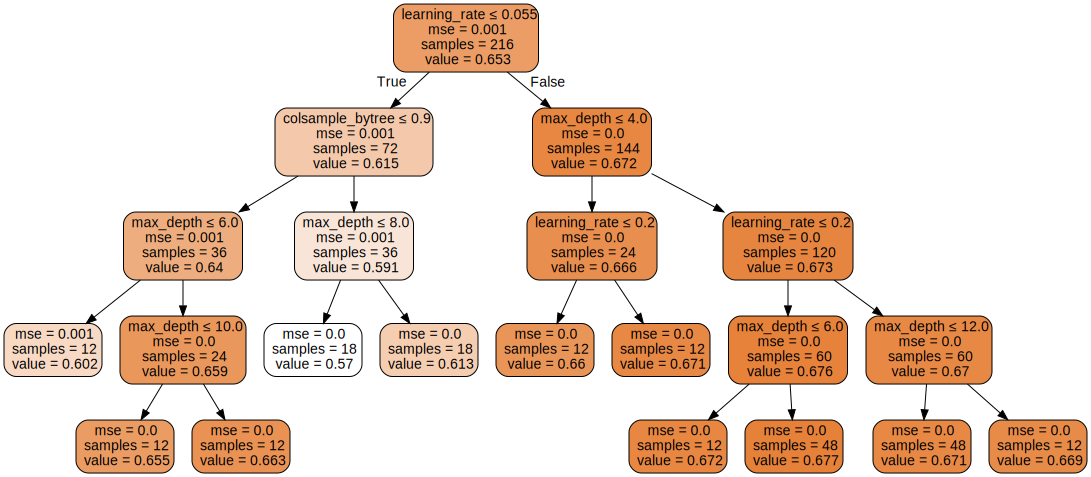

In [71]:
out_file = 'model_tuning/xgb_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=xgb_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

## Overall Validation Performance

In [46]:
models = ['catboost/factors', 'lightgbm/dummies', 'lightgbm/factors', 'xgboost/dummies']
df = pd.DataFrame()
with pd.HDFStore('results.h5') as store:
    for k in models:
        model = k.split('/')[0]
        data = k.split('/')[1]
        df = pd.concat([df, store[k][['train', 'valid', 'time']].assign(model=model, data=data)])
df['model_type'] = df.model.str.capitalize().str.cat(df.data.str.capitalize(), sep=' ')        
df = df.drop(['model', 'data'], axis=1)
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 0 to 144
Data columns (total 4 columns):
train         744 non-null float64
valid         744 non-null float64
time          744 non-null float64
model_type    744 non-null object
dtypes: float64(3), object(1)
memory usage: 29.1+ KB


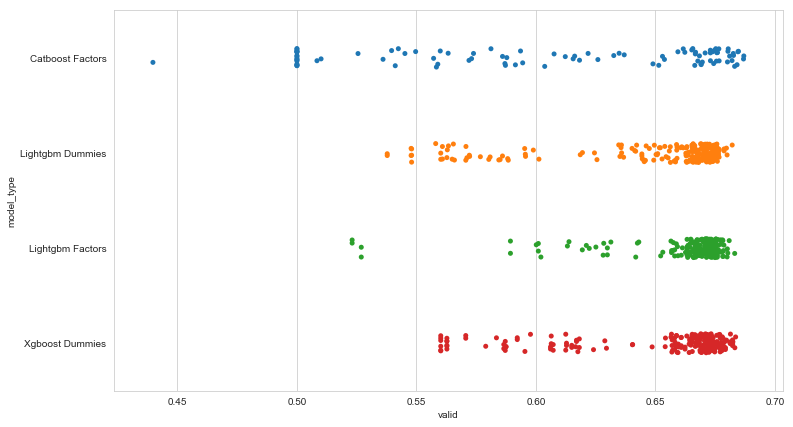

In [47]:
sns.stripplot(x='valid', y='model_type', data=df);

### LightGBM vs XGBoost

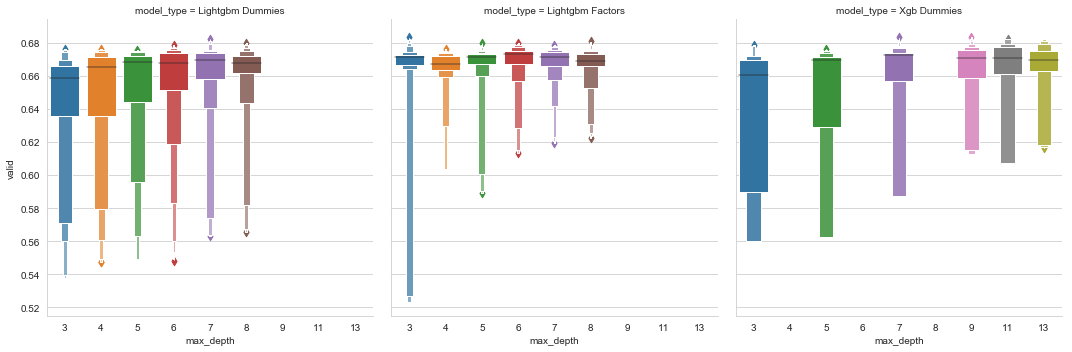

In [40]:
sns.catplot(x='max_depth', y='valid', col='model_type', data=df, kind='boxen');

In [37]:
features = ['boosting','learning_rate', 'max_depth', 'colsample_bytree', 'min_gain_to_split']
path = Path('model_tuning')
for model, data in df.groupby('model_type'):
    y = data.valid 
    X = pd.get_dummies(data[features].dropna(how='all', axis=1), columns=features, drop_first=True)
    ols = OLS(endog=y, exog=add_constant(X)).fit(cov_type='HC3')
    print('\n', model)
    print(ols.summary())
    plt.rc('figure', figsize=(12, 7))
    plt.text(0.01, 0.05, str(ols.summary()), {'fontsize': 14}, fontproperties = 'monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
    plt.savefig(path / f'{model}.png', bbox_inches='tight', dpi=300)
    plt.close();    


 lightgbm_dummies
                            OLS Regression Results                            
Dep. Variable:                  valid   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     30.77
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           1.37e-37
Time:                        20:50:19   Log-Likelihood:                 541.61
No. Observations:                 216   AIC:                            -1059.
Df Residuals:                     204   BIC:                            -1019.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const        

### CatBoost